# data visualization

## Load Libraries

In [1]:
import pandas as pd
import anndata
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import MCMC, NUTS
from pyro.contrib.autoguide import AutoDelta
from pyro import poutine
import pyro.ops.stats as stats

import numpyro as npp
import numpyro.distributions as nppdist
from numpyro.infer import MCMC as nppMCMC, NUTS as nppNUTS
import jax
from jax import lax
import jax.numpy as jnp
from numpyro.infer import Predictive
from numpyro.diagnostics import effective_sample_size as ess, split_gelman_rubin as r_hat


## Load Data

In [26]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata

quant_neuropath = pd.read_csv("sea-ad_all_mtg_quant_neuropath_bydonorid_081122.csv", index_col=0)

quant_neuropath.drop(quant_neuropath.columns[(quant_neuropath.columns.str.startswith("Donor ID"))], axis=1, inplace=True)
quant_neuropath.drop(quant_neuropath.columns[(quant_neuropath.columns.str.startswith("total"))], axis=1, inplace=True)
quant_neuropath.drop(quant_neuropath.columns[(quant_neuropath.columns.str.startswith("number of")) & ~(quant_neuropath.columns.str.contains("per area"))], axis=1, inplace=True)
quant_neuropath.drop(quant_neuropath.columns[(quant_neuropath.columns.str.contains("area analyzed"))], axis=1, inplace=True)
quant_neuropath.drop(quant_neuropath.columns[(quant_neuropath.columns.str.contains("analysis region"))], axis=1, inplace=True)

with pd.option_context("display.max_columns", None):
    quant_neuropath.index = [str(i) for i in quant_neuropath.index]

print(quant_neuropath.to_numpy().shape)

quant_neuropath.drop(quant_neuropath.columns[(quant_neuropath.columns.str.contains("case number"))], axis=1, inplace=True)
quant_neuropath.drop(quant_neuropath.columns[(quant_neuropath.columns.str.contains("pTDP43"))], axis=1, inplace=True)
quant_neuropath.drop(quant_neuropath.columns[(quant_neuropath.columns.str.contains("aSyn"))], axis=1, inplace=True)
quant_neuropath.drop(quant_neuropath.columns[(quant_neuropath.columns.str.contains("Grey"))], axis=1, inplace=True)
quant_neuropath.iloc[26, 61] =  quant_neuropath.iloc[26, 61].max()/10e5
quant_neuropath.iloc[26, 63] =  quant_neuropath.iloc[26, 63].max()/10e5

qna = anndata.AnnData(X=quant_neuropath)

sc.pp.scale(qna,zero_center=False)
sc.pp.pca(qna)

initial_cond = np.argsort(qna.obsm['X_pca'][:, 0])
matrix=  qna.X


(84, 218)


In [27]:
quant_neuropath.index = [str(i) for i in quant_neuropath.index]
quant_neuropath.index

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72',
       '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83'],
      dtype='object')

In [32]:
strlist = ["percent 6e10 positive area", "percent of Iba1 and 6e10 positive co-localized objects",
           "number of Iba1 and 6e10 positive co-localized objects per area", "percent AT8 positive area",
           "number of 6e10 positive objects per area", "number of AT8 positive cells per area",
           "average 6e10 positive object area","percent NeuN positive area",
           "number of NeuN strong positive cells per area", "percent GFAP positive area",
           "average AT8 positive cell area", "average Iba1 positive process area per cell",
           "number of inactivated Iba1 positive cells per area", "number of Hematoxylin positive nuclei per area",
           "percent Iba1 positive area", "average GFAP positive branch area"]

In [33]:
Nf = 16
subsets = []
for i in range(Nf):
    subsets.append(quant_neuropath[quant_neuropath.columns[(quant_neuropath.columns.str.contains(strlist[i]))]])

nsub = np.arange(len(strlist))
quant_neuropath_subset = pd.concat(subsets, axis=1).reindex(subsets[0].index)
qna = anndata.AnnData(X=quant_neuropath_subset)

#Mariano's solution: scale and sort according to PCA
sc.pp.scale(qna,zero_center=False)
sc.pp.pca(qna)

matrix = qna.X

T = matrix.shape[0]
L = 5
M = int(matrix.shape[1]/L)

datas0 = np.zeros((M, L, T))
for n in np.arange(M):
    for m in range(L):
        k = L*n + m
        #I am inflating the counts just because it is good for poisson estimation, although this is certainly handwavy
        datas0[n, m, :] = matrix[initial_cond, k]

In [34]:
import arviz as az

In [35]:
ffModelFeatures = pd.read_pickle('NB_exp_ff_'+str(12))
import arviz as az
ffObject_12Feat = az.concat(ffModelFeatures['az_objects'][0],ffModelFeatures['az_objects'][1],ffModelFeatures['az_objects'][2], ffModelFeatures['az_objects'][3],ffModelFeatures['az_objects'][4],dim='chain')
posterior_samples = ffObject_12Feat['posterior']
posterior_predictive = ffObject_12Feat['posterior_predictive']
data = datas0

In [36]:
posterior_predictive["obs"].mean(axis=(0,1)).shape

(12, 5, 84)

I0000 00:00:1716579873.618836       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


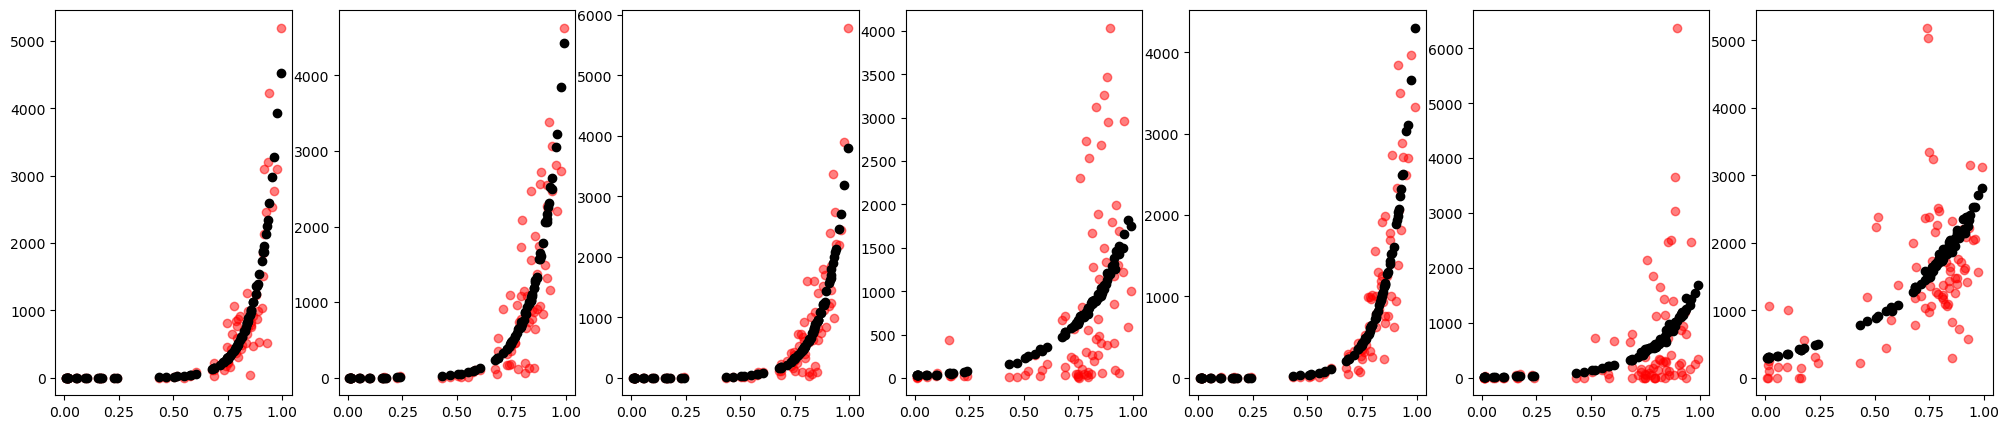

In [37]:
# Plot posterior predictive with data fits
times = posterior_samples["times"].mean(axis=0).mean(axis=0)
fig, ax = plt.subplots(1,7, figsize=(25,5))
for i in range(7):
    ax[i].scatter(times, jnp.int32(jnp.array(1000 * data[i, 0, :])),c='r', alpha=0.5)
    ax[i].scatter(times, posterior_predictive["obs"].mean(axis=(0,1))[i,0,:],c='k')

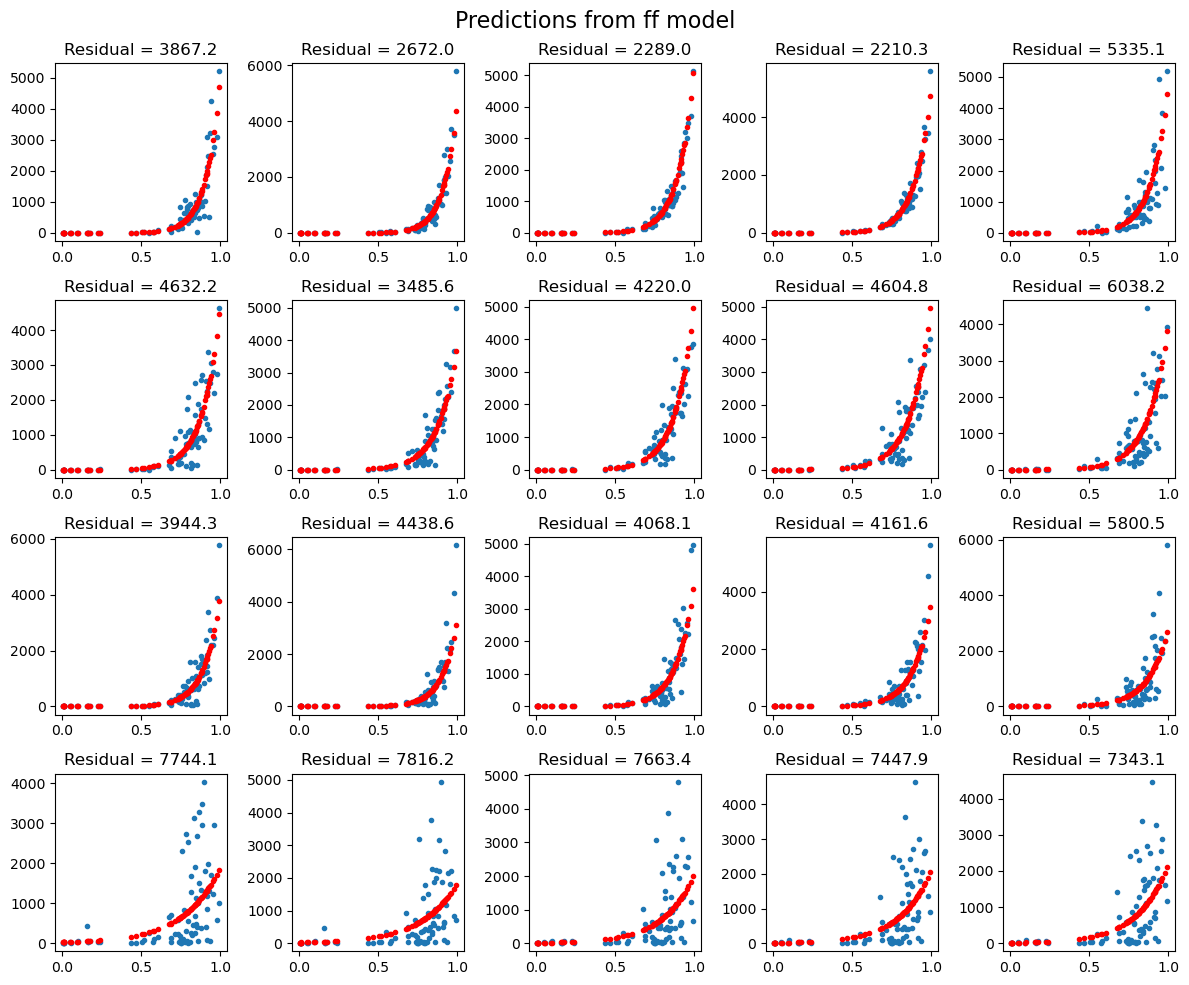

In [38]:
from scipy import stats
totNf = 12
nf = 4

ffModelFeatures = pd.read_pickle('NB_exp_ff_12')
b0 = ffModelFeatures['betas0'].mean(0)
b1 = ffModelFeatures['betas1'].mean(0)
t = ffModelFeatures['times'].mean(0)
a = ffModelFeatures['a'].mean(0).transpose()

fig, ax = plt.subplots(nf, 5, figsize=(12, 10))
Nlayers = 5
for n in range(nf): 
    for l in np.arange(Nlayers): 
        ax[n,l].plot(t, jnp.int32(1000*datas0[n,l, :]), '.')
        ax[n,l].plot(t, a[n, l] * jnp.exp(b0[n,l] + b1[n,l] * t), '.r')
        residual = np.linalg.norm(jnp.int32(1000*datas0[n,l, :]) - a[n, l] * jnp.exp(b0[n,l] + b1[n,l] * t))
        ax[n,l].set_title('Residual = '+str(np.round(residual,1)))
fig.suptitle('Predictions from ff model', fontsize=16)

plt.tight_layout()

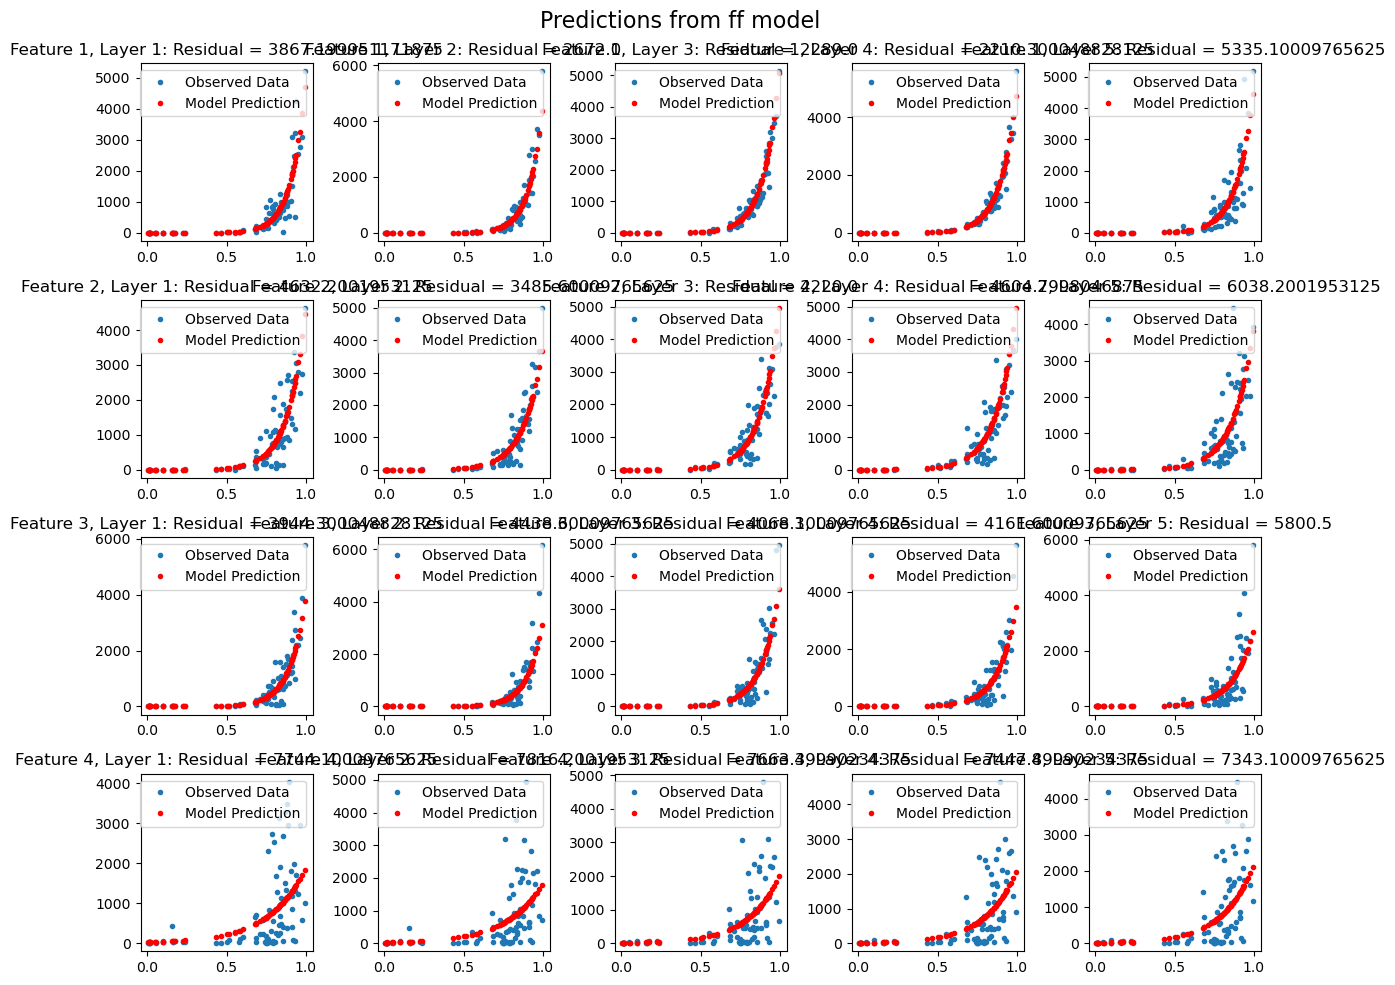

In [39]:
from scipy import stats
totNf = 12
nf = 4

ffModelFeatures = pd.read_pickle('NB_exp_ff_12')
b0 = ffModelFeatures['betas0'].mean(0)
b1 = ffModelFeatures['betas1'].mean(0)
t = ffModelFeatures['times'].mean(0)
a = ffModelFeatures['a'].mean(0).transpose()

fig, ax = plt.subplots(nf, 5, figsize=(12, 10))
Nlayers = 5
for n in range(nf): 
    for l in np.arange(Nlayers): 
        ax[n,l].plot(t, jnp.int32(1000*datas0[n,l, :]), '.', label='Observed Data')
        ax[n,l].plot(t, a[n, l] * jnp.exp(b0[n,l] + b1[n,l] * t), '.r', label='Model Prediction')
        residual = np.linalg.norm(jnp.int32(1000*datas0[n,l, :]) - a[n, l] * jnp.exp(b0[n,l] + b1[n,l] * t))
        ax[n,l].set_title(f'Feature {n+1}, Layer {l+1}: Residual = {np.round(residual,1)}')
        ax[n,l].legend()
fig.suptitle('Predictions from ff model', fontsize=16)

plt.tight_layout()

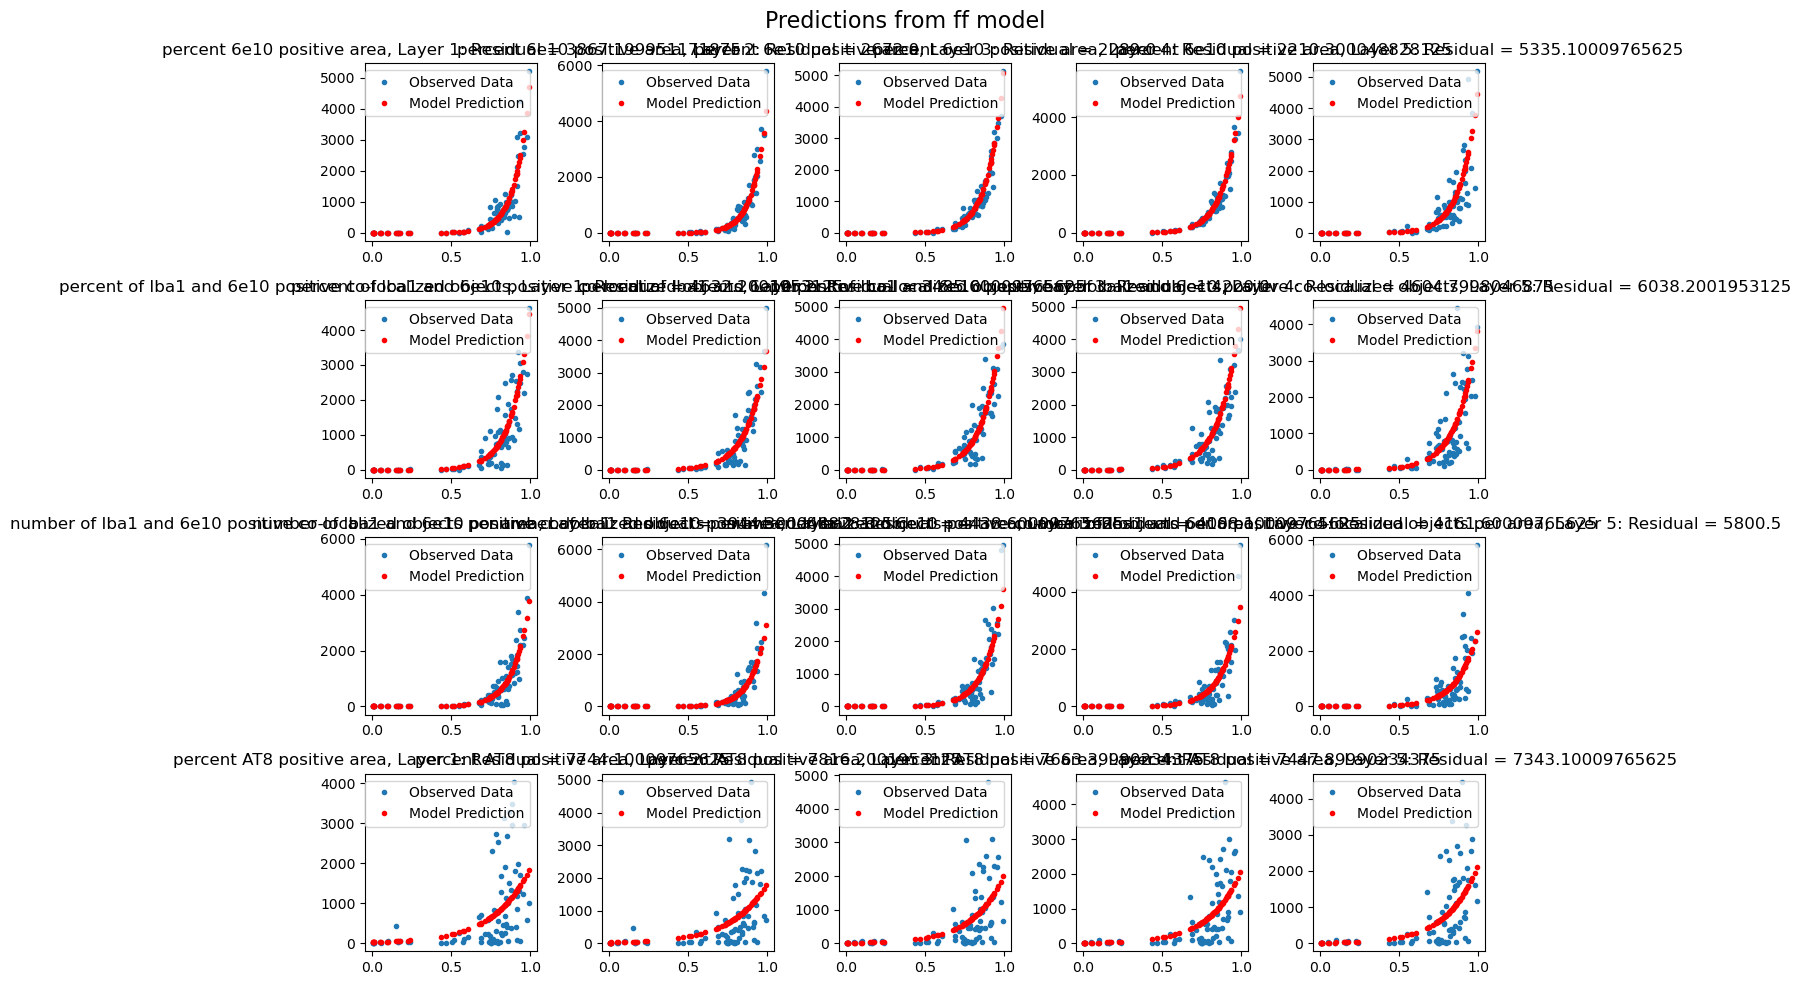

In [40]:
from scipy import stats
totNf = 12
nf = 4

ffModelFeatures = pd.read_pickle('NB_exp_ff_12')
b0 = ffModelFeatures['betas0'].mean(0)
b1 = ffModelFeatures['betas1'].mean(0)
t = ffModelFeatures['times'].mean(0)
a = ffModelFeatures['a'].mean(0).transpose()

feature_names = strlist[:totNf] 

fig, ax = plt.subplots(nf, 5, figsize=(12, 10))
Nlayers = 5
for n in range(nf): 
    for l in np.arange(Nlayers): 
        ax[n,l].plot(t, jnp.int32(1000*datas0[n,l, :]), '.', label='Observed Data')
        ax[n,l].plot(t, a[n, l] * jnp.exp(b0[n,l] + b1[n,l] * t), '.r', label='Model Prediction')
        residual = np.linalg.norm(jnp.int32(1000*datas0[n,l, :]) - a[n, l] * jnp.exp(b0[n,l] + b1[n,l] * t))
        ax[n,l].set_title(f'{feature_names[n]}, Layer {l+1}: Residual = {np.round(residual,1)}')
        ax[n,l].legend()
fig.suptitle('Predictions from ff model', fontsize=16)
plt.tight_layout()

In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot
import pandas as pd
import numpy as np
import jax.numpy as jnp


#pplt.plot and data in the order of the time in ascending order...
ffModelFeatures = pd.read_pickle('NB_exp_ff_12')
b0 = ffModelFeatures['betas0'].mean(0)
b1 = ffModelFeatures['betas1'].mean(0)
t = ffModelFeatures['times'].mean(0)
a = ffModelFeatures['a'].mean(0).transpose()

feature_names = strlist[:12] 
fig = make_subplots(rows=1, cols=1)

traces = []
annotations = []

nf = 4  
Nlayers = 5

for n in range(nf):
    for l in range(Nlayers):
        observed_data = jnp.int32(1000 * datas0[n, l, :])
        model_prediction = a[n, l] * jnp.exp(b0[n, l] + b1[n, l] * t)
        residual = np.linalg.norm(observed_data - model_prediction)

        trace_observed = go.Scatter(x=t, y=observed_data, mode='markers', name='Observed Data', marker=dict(color='blue'), visible=False)
        trace_model = go.Scatter(x=t, y=model_prediction, mode='markers', name='Model Prediction', line=dict(color='red'), visible=False)

        traces.append(trace_observed)
        traces.append(trace_model)

        annotation = dict(
            text=f'MTG Layers',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0.5,
            y=1.15,
            xanchor='center',
            yanchor='bottom',
            font=dict(size=14),
            visible=False
        )
        annotations.append(annotation)


fig.add_traces(traces)
fig.update_layout(annotations=annotations)

buttons = []
for n in range(nf):
    for l in range(Nlayers):
        visibility = [False] * len(traces)
        visibility[2 * (n * Nlayers + l)] = True
        visibility[2 * (n * Nlayers + l) + 1] = True
        for i in range(len(annotations)):
            annotations[i]['visible'] = (i == (n * Nlayers + l))

        buttons.append(dict(
            label=f'{feature_names[n]}, Layer {l+1}',
            method='update',
            args=[{'visible': visibility},
                  {'annotations': annotations}]
        ))

fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=0.1,
        y=1.15,
        xanchor='left',
        yanchor='top'
    )],
    height=600,
    width=800,
    #title_text='Feature and Layer Selection'
)

for i in range(2):
    traces[i].visible = True
annotations[0]['visible'] = True

fig.show()
plot(fig, filename = 'MTG_INFERENCE.html', auto_open=True)

'MTG_INFERENCE.html'

In [43]:
strlist

['percent 6e10 positive area',
 'percent of Iba1 and 6e10 positive co-localized objects',
 'number of Iba1 and 6e10 positive co-localized objects per area',
 'percent AT8 positive area',
 'number of 6e10 positive objects per area',
 'number of AT8 positive cells per area',
 'average 6e10 positive object area',
 'percent NeuN positive area',
 'number of NeuN strong positive cells per area',
 'percent GFAP positive area',
 'average AT8 positive cell area',
 'average Iba1 positive process area per cell',
 'number of inactivated Iba1 positive cells per area',
 'number of Hematoxylin positive nuclei per area',
 'percent Iba1 positive area',
 'average GFAP positive branch area']